# Topic Selection of LDA Model

### MODEL SELECTION

In [1]:
# Built-in packages
import string
import os
import time as t
import warnings
import sys

# To ignore all warnings that arise here to enhance clarity
warnings.filterwarnings('ignore')

# Basic Packages for Data Wrangling
import spacy
import pymysql
import pandas as pd
import numpy as np
from numpy import array
import datetime as dt
import pycountry as pc # Country Name Converter

import matplotlib.pyplot as plt # For data visualisation
import seaborn as sns # For data visualisation
import re # For regular expression
from tqdm import tqdm # Processing bar
from zhon import hanzi # For handling the chinsese punctuation
from scipy.optimize import linear_sum_assignment # For hungarian algorithm

# Data Scrapy
import requests
from lxml import etree
import xml.etree.ElementTree as et
from itertools import chain
from itertools import combinations

# NLTK for processing stop words
from nltk.corpus import stopwords
import nltk
from nltk.stem import PorterStemmer # Great stemmer
from nltk.stem import LancasterStemmer # over-stemming easily, more aggresive stemmer
from nltk.stem.snowball import SnowballStemmer # stemmer for non-english languages
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer # lemmatizer (词形还原)
from sklearn.feature_extraction.text import TfidfVectorizer # get tf-idf matrix
from pyinflect import getAllInflections # get inflect words

# For LDA model
import gensim
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim.utils import simple_preprocess
import gensim.corpora as corpora

In [2]:
from numpy.random import default_rng
def compute_coherence_values(dictionary, corpus, texts, limit, single_model_repeat = 10, LDA_iterations = 10000, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    def topic_number_generator(start, limit, step):
        res = [start] if start % step != 0 else []
        for num_topic in range(start, limit + 1):
            if num_topic % step == 0:
                res.append(num_topic)
        return res
    
    model_list = []
    coherence_list = []
    topic_num_list = topic_number_generator(start,limit,step)
    for num_topic in topic_num_list:
        coherence_values = []
        models = []
        for elem in tqdm(range(single_model_repeat)):
            model = LdaModel(corpus=corpus, num_topics=num_topic, id2word=dictionary, iterations = LDA_iterations, random_state=elem)
            models.append(model)
            model.save("../Results/new_res_model8/model_topic{0}_{1}".format(num_topic, elem))
            coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
            coherence_values.append(coherencemodel.get_coherence())
        coherence_list.append(coherence_values)
        save_word_list("../Results/new_res_model8/cohe_topic{}.txt".format(num_topic), coherence_values)
        model_list.append(models)
    return model_list, coherence_list

In [3]:
def plot_difference_plotly(mdiff, title="", annotation=None):
    """Plot the difference between models.

    Uses plotly as the backend."""
    import plotly.graph_objs as go
    import plotly.offline as py

    annotation_html = None
    if annotation is not None:
        annotation_html = [
            [
                "+++ {}<br>--- {}".format(", ".join(int_tokens), ", ".join(diff_tokens))
                for (int_tokens, diff_tokens) in row
            ]
            for row in annotation
        ]

    data = go.Heatmap(z=mdiff, colorscale='RdBu', text=annotation_html)
    layout = go.Layout(width=950, height=950, title=title, xaxis=dict(title="topic"), yaxis=dict(title="topic"))
    py.iplot(dict(data=[data], layout=layout))


def plot_difference_matplotlib(mdiff, title="", annotation=None):
    """Helper function to plot difference between models.

    Uses matplotlib as the backend."""
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(18, 14))
    data = ax.imshow(mdiff, cmap='RdBu_r', origin='lower')
    plt.title(title)
    plt.colorbar(data)
    
    
try:
    get_ipython()
    import plotly.offline as py
except Exception:
    #
    # Fall back to matplotlib if we're not in a notebook, or if plotly is
    # unavailable for whatever reason.
    #
    plot_difference = plot_difference_matplotlib
else:
    py.init_notebook_mode()
    plot_difference = plot_difference_plotly

In [4]:
def read_word_list(path = '../Data/unimportant_stemmed_words_ALL.txt'):
    with open(path, 'r') as f:
        content = f.readlines()
    # you may also want to remove whitespace characters like `\n` at the end of each line
    return [x.replace("\n", '').strip() for x in content]

In [5]:
# # Can take a long time to run.
# model_list, coherence_list = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_ready, start=8, limit=10, step=2, single_model_repeat = 30)

In [6]:
def get_similarity(m1, m2, dist_metd = 'jensen_shannon', avg = True):
    mdiff, _ = m1.diff(m2, distance=dist_metd)
    row_ind, col_ind = linear_sum_assignment(mdiff)
    return mdiff[row_ind, col_ind].sum()/len(mdiff[row_ind, col_ind]) if avg else mdiff[row_ind, col_ind]

def get_stability(mList):
    sim_sum = 0
    r = len(mList)
    for models in list(combinations(mList, 2)):
        sim_sum += get_similarity(models[0], models[1])
    return(2/r * (r-1)) * sim_sum



def topic_number_generator(start, limit, step):
    res = [start] if start % step != 0 else []
    for num_topic in range(start, limit + 1):
        if num_topic % step == 0:
            res.append(num_topic)
    return res

In [7]:
numList = topic_number_generator(2, 65, 2)

In [8]:
cvList = []
for num in numList:
    cvs = read_word_list("../Results/topic_selection_res/cohe_topic{}.txt".format(num))
    cvs = [float(elem) for elem in cvs]
    cvList.append(cvs)

In [9]:
dic = {}
for i in range(len(cvList)):
    dic[numList[i]] = cvList[i]

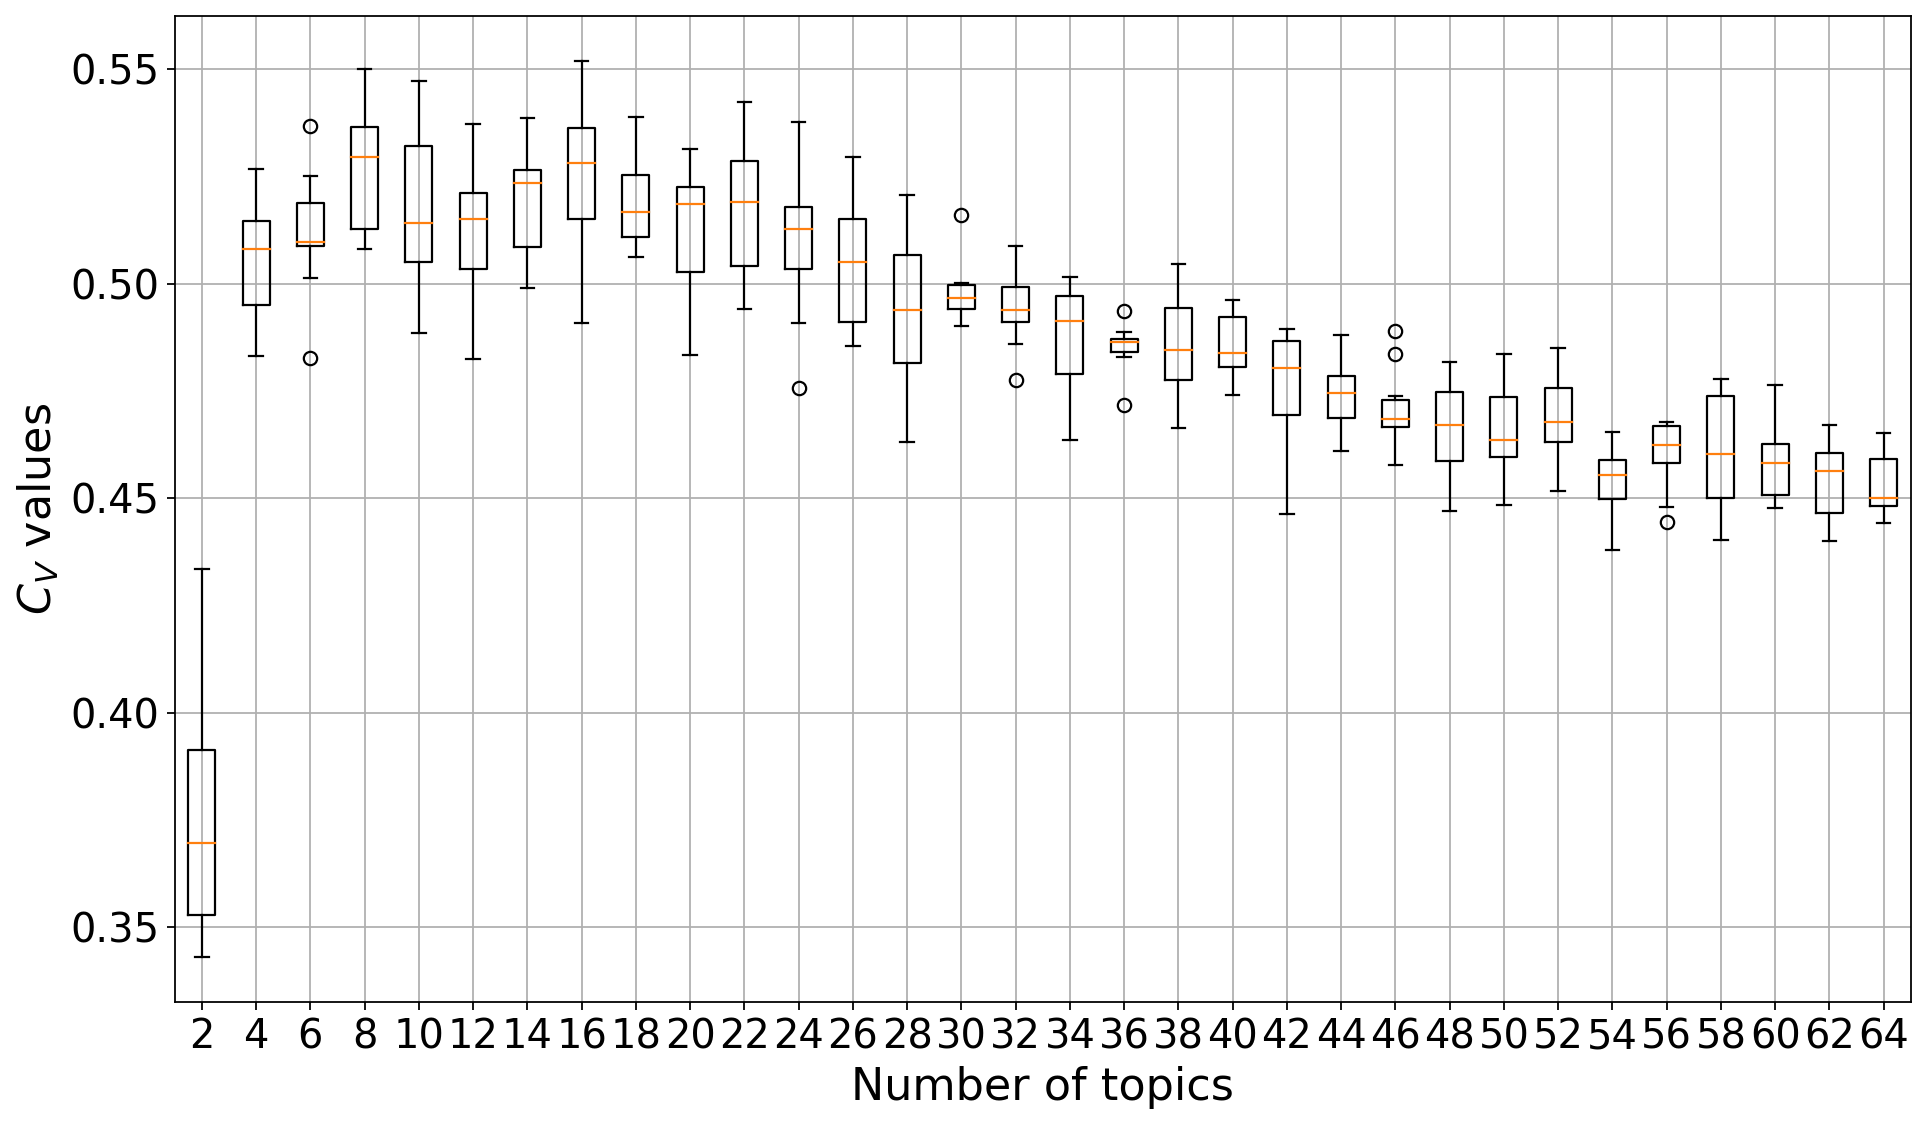

In [10]:
plt.style.use('default')
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (14,8), dpi = 160)
ax.boxplot(dic.values())
plt.yticks(fontsize=18)
ax.set_xticklabels(dic.keys(), fontsize = 18)
ax.set_ylabel(r'$C_V$ values', color='black', fontsize = 20)
ax.set_xlabel('Number of topics', color='black', fontsize = 20)
ax.grid(True)
# plt.xticks(np.arange(min(topicList), max(topicList)+1, 2.0))
# ax.set_title('CV Boxplot for Topic Models with topic from 2 to 64', fontdict=dict(size=16, color='black'))
fig.savefig("../project_latex/img/topic_selection2.pdf")

In [11]:
topicList = topic_number_generator(2,65,2)
mList = []
for topic in topicList:
    m = []
    for i in range(10):
        m.append(gensim.models.ldamodel.LdaModel.load('../Results/topic_selection_res/model_topic{0}_{1}'.format(topic, i)))
    mList.append(m)

In [12]:
simdic = {}
for i in range(len(mList)):
    simdic[topicList[i]] = [get_similarity(models[0], models[1]) for models in list(combinations(mList[i], 2))]

In [13]:
stabList = []
for i in range(len(mList)):
    stabList.append(get_stability(mList[i]))

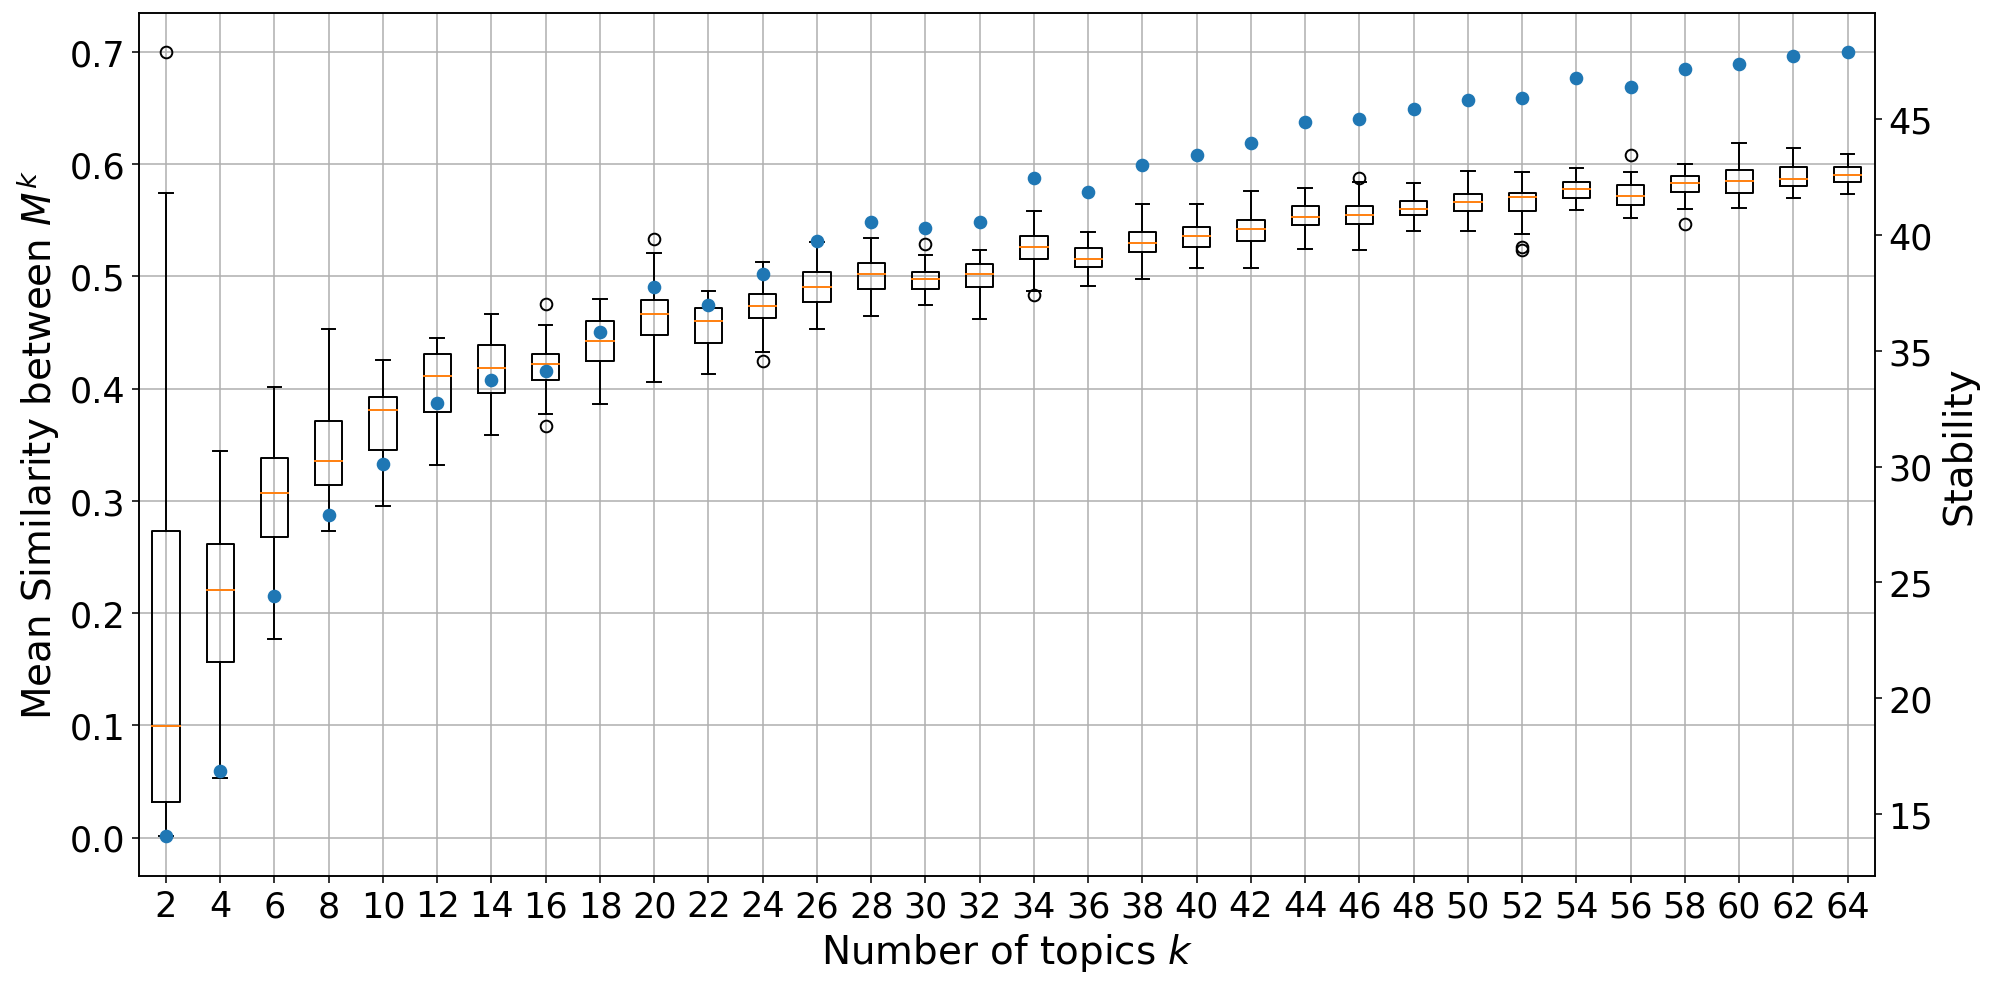

In [14]:
plt.style.use('default')
fig, ax1 = plt.subplots(1, 1, figsize = (16,8), dpi = 140)

ax1.boxplot(simdic.values())
ax1.set_xticklabels(simdic.keys(), fontsize = 20)
ax1.set_ylabel(r'Mean Similarity between $M^k$', color='black', fontsize = 20)
ax1.set_xlabel(r'Number of topics $k$', color='black', fontsize = 20)
ax1.tick_params(axis='both', labelsize=18)
ax1.grid(True)

ax2 = ax1.twinx()
ax2.scatter(range(1,33), stabList)
# ax2.set_xticklabels(simdic.keys(), fontsize = 20)
ax2.set_ylabel('Stability', color='black', fontsize = 20)
ax2.tick_params(axis='both', labelsize=18)

# def get_axis_limits(ax, scale=.9):
#     return (ax.get_xlim()[0]*scale, ax.get_ylim()[1]*scale)

# ax1.text(get_axis_limits(ax1, scale=1)[0], get_axis_limits(ax1, scale=1.01)[1], 'A', fontsize = 18, weight = 'bold')
# ax2.text(get_axis_limits(ax2, scale=1)[0], get_axis_limits(ax2, scale=1.01)[1], 'B', fontsize = 18, weight = 'bold')

# plt.tight_layout()
fig.savefig("../project_latex/img/jsd_boxplot2.pdf")
# plt.show()